In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import shap
import seaborn as sns
import lightgbm as lgb


In [3]:
# index_col=0就可以避免出现Unnamed列
datas = pd.read_csv("mp2116datas(containOs,Ir).csv", index_col=0,)

# 给每列改名，方便后面画图
new_col_names = []
for col_name in datas.columns[2:]:
    _pos = col_name.find("_")
    new_name = "$" + col_name[: _pos + 1] + "{" + col_name[_pos + 1:] + "}$"
    new_col_names.append(new_name)

datas.columns = ["Formula", "Nature of Bandgap"] + new_col_names

datas.head()

,Formula,Nature of Bandgap,$A_{Z}$,$A_{Ra}$,$A_{Rvdw}$,$A_{Pcov}$,$A_{Xp}$,$A_{Nv}$,$A_{Eie}$,$A_{Dp}$,...,$X_{Eie}$,$X_{Dp}$,$A_{Os}$,$B1_{Os}$,$B2_{Os}$,$X_{Os}$,$A_{Ir}$,$B1_{Ir}$,$B2_{Ir}$,$X_{Ir}$
0,Sr2 Hf1 W1 O6,0,38,279,364.1,185.0,0.95,2.0,549.5,197.2,...,1313.9,5.30,2.0,4.0,4.0,-2.0,1.32,0.850,0.80,1.26
1,Cs2 Al1 Au1 I6,0,55,249,451.7,232.0,0.79,1.0,375.7,400.9,...,1008.4,32.90,1.0,3.0,1.0,-1.0,1.81,0.675,1.51,2.06
2,Na2 Ge1 Te1 O6,0,11,225,298.3,155.0,0.93,1.0,495.8,162.7,...,1313.9,5.30,1.0,4.0,6.0,-2.0,1.16,0.670,0.70,1.26
3,Mn2 Fe1 Sb1 O6,0,25,242,296.1,119.0,1.55,7.0,717.3,68.0,...,1313.9,5.30,2.0,3.0,5.0,-2.0,0.97,0.785,0.76,1.26
4,Rb2 Tl1 Sb1 F6,0,37,240,411.4,210.0,0.82,1.0,403.0,319.8,...,1681.0,3.74,1.0,1.0,3.0,-1.0,1.66,1.640,0.90,1.19


查看数据分布(标签分布算是正常)

In [4]:
gap_nature_dist = datas["Nature of Bandgap"].value_counts()

Text(0.95, 800, '756')

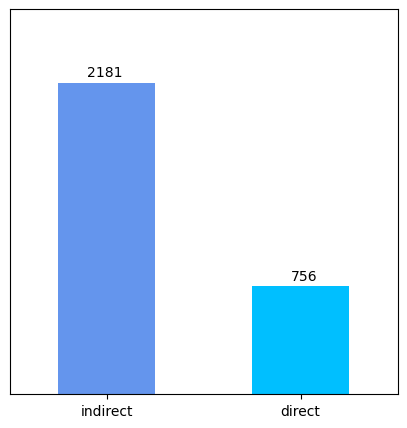

In [5]:
import numpy as np
gap_nature_dist = datas["Nature of Bandgap"].value_counts()
gap_nature_dist.index=["indirect", "direct"]
plt.subplots(figsize=(5,5))
plt.bar(gap_nature_dist.index, gap_nature_dist.values, width=0.5, color=["cornflowerblue", "deepskyblue"])
plt.yticks(())
plt.ylim(0, 2700)
plt.xlim(-0.5, 1.5)
plt.text(-0.1,2230,"2181")
plt.text(0.95, 800,"756")

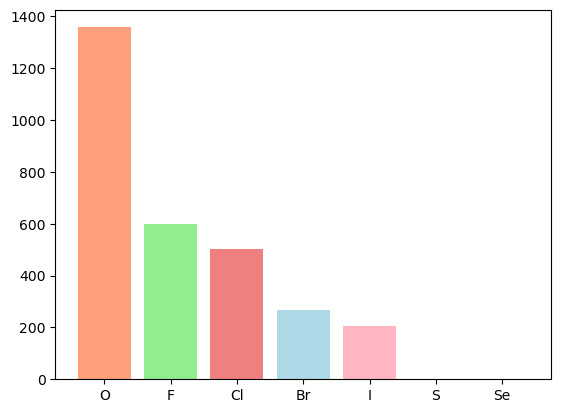

In [6]:
X_site_counts = datas['Formula'].apply(lambda x: x[-3:-1].strip()).value_counts()
plt.bar(X_site_counts.index, X_site_counts.values, color=['lightsalmon', 'lightgreen', 'lightcoral', 
                                                            'lightblue', 'lightpink', 'lightcyan', 'violet'])
plt.show()

特征相关性热力图

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

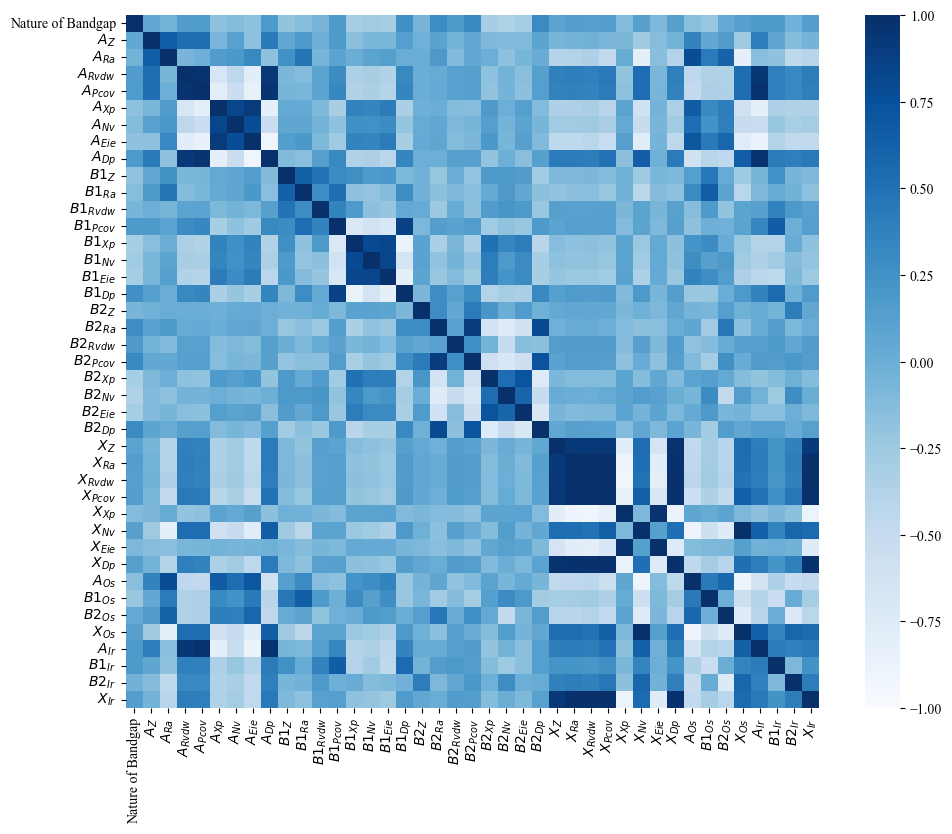

In [20]:
df_coor = datas.corr()
plt.subplots(figsize=(12,9),facecolor="w")
plt.rc ('font',family='Times New Roman')

fig = sns.heatmap(df_coor, square=True, cmap="Blues",vmax=1, vmin=-1)
fig

In [8]:
abs_df_coor = np.abs(df_coor)
bool_df_coor = np.logical_and(abs_df_coor > 0.8, abs_df_coor < 1)
bool_df_coor.iloc[0, :] = True
bool_df_coor["Nature of Bandgap"] = True
f = df_coor[bool_df_coor]
f

,Nature of Bandgap,$A_{Z}$,$A_{Ra}$,$A_{Rvdw}$,$A_{Pcov}$,$A_{Xp}$,$A_{Nv}$,$A_{Eie}$,$A_{Dp}$,$B1_{Z}$,...,$X_{Eie}$,$X_{Dp}$,$A_{Os}$,$B1_{Os}$,$B2_{Os}$,$X_{Os}$,$A_{Ir}$,$B1_{Ir}$,$B2_{Ir}$,$X_{Ir}$
Nature of Bandgap,1.000000,0.051478,-0.039575,0.160615,0.170361,-0.166508,-0.124676,-0.172869,0.177291,-0.190105,...,-0.086628,0.121985,-0.143052,-0.222803,0.045172,0.124683,0.182801,0.172248,-0.032665,0.146700
$A_{Z}$,0.051478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$A_{Ra}$,-0.039575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.808589,NaN,NaN,NaN,NaN
$A_{Rvdw}$,0.160615,NaN,NaN,NaN,0.973690,NaN,NaN,NaN,0.933721,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.940593,NaN,NaN,NaN
$A_{Pcov}$,0.170361,NaN,NaN,0.973690,NaN,NaN,NaN,-0.846118,0.966669,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.969102,NaN,NaN,NaN
$A_{Xp}$,-0.166508,NaN,NaN,NaN,NaN,NaN,0.835296,0.906441,-0.806937,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.818727,NaN,NaN,NaN
$A_{Nv}$,-0.124676,NaN,NaN,NaN,NaN,0.835296,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$A_{Eie}$,-0.172869,NaN,NaN,NaN,-0.846118,0.906441,NaN,NaN,-0.903384,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.874908,NaN,NaN,NaN
$A_{Dp}$,0.177291,NaN,NaN,0.933721,0.966669,-0.806937,NaN,-0.903384,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.973828,NaN,NaN,NaN
$B1_{Z}$,-0.190105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
new_col_names[8:]

['$B1_{Z}$',
 '$B1_{Ra}$',
 '$B1_{Rvdw}$',
 '$B1_{Pcov}$',
 '$B1_{Xp}$',
 '$B1_{Nv}$',
 '$B1_{Eie}$',
 '$B1_{Dp}$',
 '$B2_{Z}$',
 '$B2_{Ra}$',
 '$B2_{Rvdw}$',
 '$B2_{Pcov}$',
 '$B2_{Xp}$',
 '$B2_{Nv}$',
 '$B2_{Eie}$',
 '$B2_{Dp}$',
 '$X_{Z}$',
 '$X_{Ra}$',
 '$X_{Rvdw}$',
 '$X_{Pcov}$',
 '$X_{Xp}$',
 '$X_{Nv}$',
 '$X_{Eie}$',
 '$X_{Dp}$',
 '$A_{Os}$',
 '$B1_{Os}$',
 '$B2_{Os}$',
 '$X_{Os}$',
 '$A_{Ir}$',
 '$B1_{Ir}$',
 '$B2_{Ir}$',
 '$X_{Ir}$']

<Axes: >

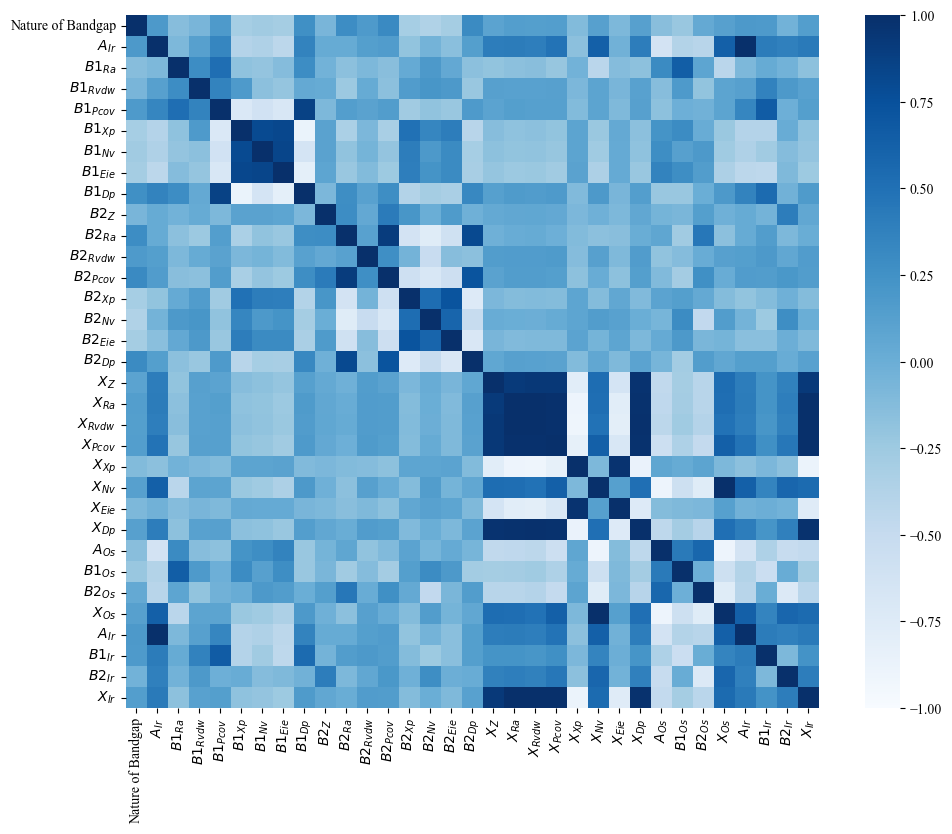

In [10]:
persisted_attrs = ["Nature of Bandgap", "$A_{Ir}$"] + new_col_names[9:]
plt.rc ('font',family='Times New Roman')
df_coor1 = datas[persisted_attrs].corr()
plt.subplots(figsize=(12,9),facecolor="w")
fig = sns.heatmap(df_coor1, square=True, cmap="Blues",vmax=1, vmin=-1)
fig

In [11]:
abs_df_coor = np.abs(df_coor1)
bool_df_coor = np.logical_and(abs_df_coor > 0.8, abs_df_coor < 1)
bool_df_coor.iloc[0, :] = True
bool_df_coor["Nature of Bandgap"] = True
f = df_coor1[bool_df_coor]
f

,Nature of Bandgap,$A_{Ir}$,$B1_{Ra}$,$B1_{Rvdw}$,$B1_{Pcov}$,$B1_{Xp}$,$B1_{Nv}$,$B1_{Eie}$,$B1_{Dp}$,$B2_{Z}$,...,$X_{Eie}$,$X_{Dp}$,$A_{Os}$,$B1_{Os}$,$B2_{Os}$,$X_{Os}$,$A_{Ir}$,$B1_{Ir}$,$B2_{Ir}$,$X_{Ir}$
Nature of Bandgap,1.000000,0.182801,-0.137256,-0.063219,0.176883,-0.304301,-0.269666,-0.291911,0.261594,-0.063979,...,-0.086628,0.121985,-0.143052,-0.222803,0.045172,0.124683,0.182801,0.172248,-0.032665,0.146700
$A_{Ir}$,0.182801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Ra}$,-0.137256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Rvdw}$,-0.063219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Pcov}$,0.176883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.864288,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Xp}$,-0.304301,NaN,NaN,NaN,NaN,NaN,0.802709,0.822050,-0.871326,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Nv}$,-0.269666,NaN,NaN,NaN,NaN,0.802709,NaN,0.837921,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Eie}$,-0.291911,NaN,NaN,NaN,NaN,0.822050,0.837921,NaN,-0.809591,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B1_{Dp}$,0.261594,NaN,NaN,NaN,0.864288,-0.871326,NaN,-0.809591,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$B2_{Z}$,-0.063979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


去除相关性很高的特征

各位点属性的数据分布画图

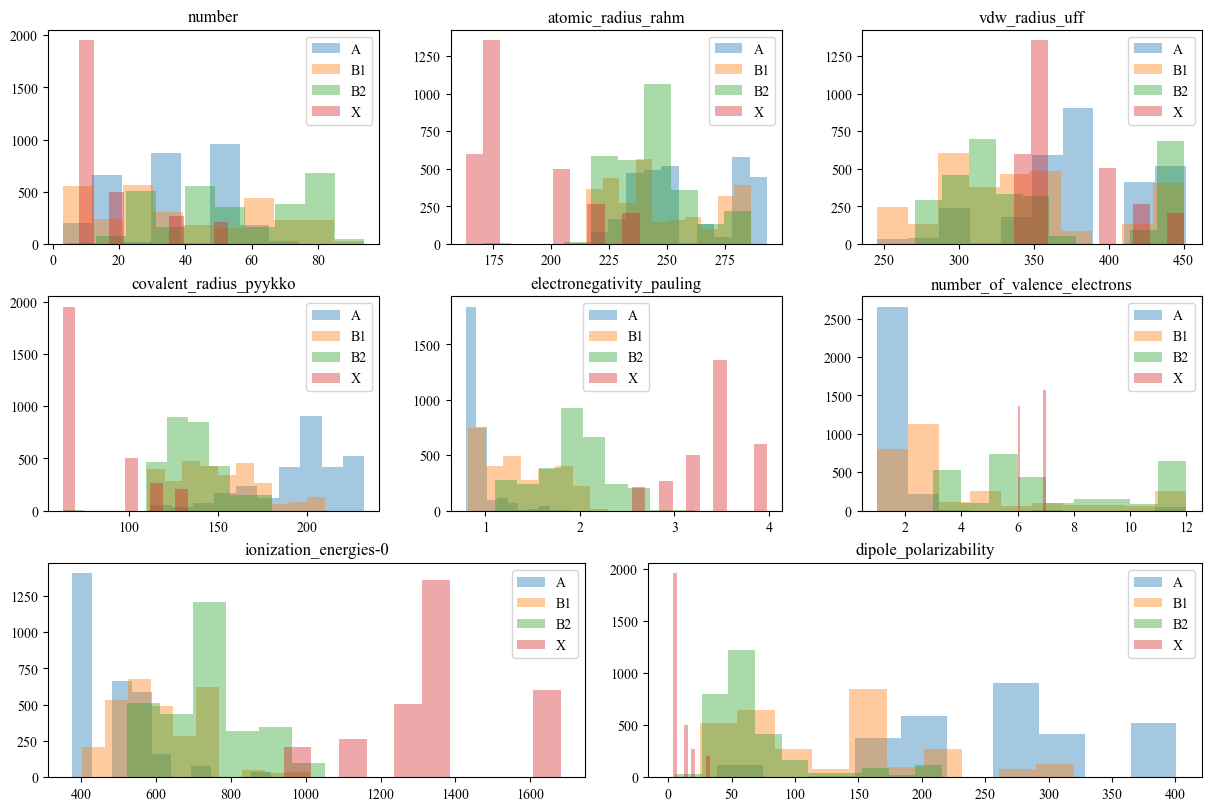

In [12]:
# 布局使用"constrained"使布局紧凑（数轴字体变小）
# 做好画板和子图布局
fig = plt.figure(figsize=(12, 8), layout="constrained")
gs = GridSpec(3, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, :2])
ax5 = fig.add_subplot(gs[1, 2:4])
ax6 = fig.add_subplot(gs[1, 4:6])
ax7 = fig.add_subplot(gs[2, :3])
ax8 = fig.add_subplot(gs[2, 3:])

title = ["number", "atomic_radius_rahm", "vdw_radius_uff","covalent_radius_pyykko", "electronegativity_pauling",
            "number_of_valence_electrons", "ionization_energies-0", "dipole_polarizability"]
attrs = ["Z", "Ra", "Rvdw", "Pcov", "Xp", "Nv", "Eie", "Dp"]
sites = ["A", "B1", "B2", "X"]
#$A_{Xp}$
for ax, title, attr in zip(fig.axes, title, attrs):
    for site in sites:
        site_attr = "$" + site+"_{"+ attr + "}$"
        ax.hist(datas[site_attr], alpha=0.4, label=site)
        ax.legend()
        ax.set_title(title)
plt.show()

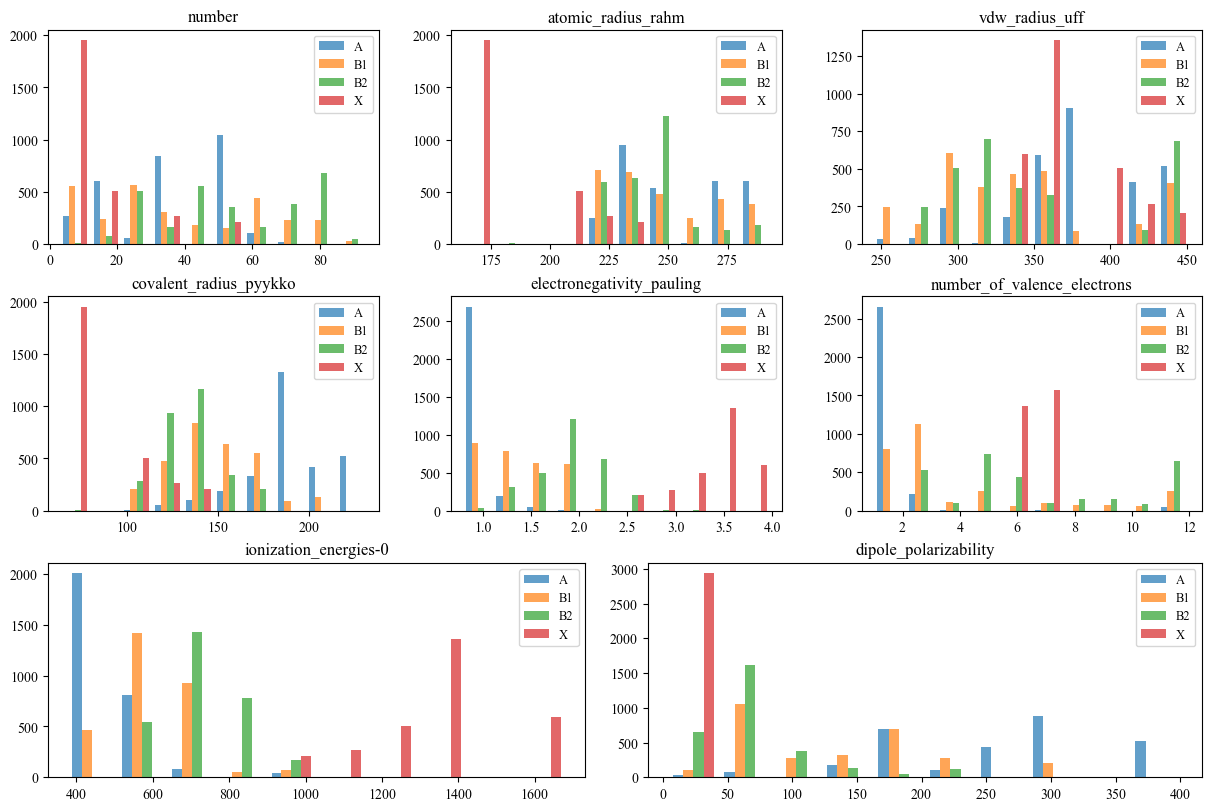

In [13]:
# 布局使用"constrained"使布局紧凑（数轴字体变小）
# 做好画板和子图布局
fig = plt.figure(figsize=(12, 8), layout="constrained")
gs = GridSpec(3, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, :2])
ax5 = fig.add_subplot(gs[1, 2:4])
ax6 = fig.add_subplot(gs[1, 4:6])
ax7 = fig.add_subplot(gs[2, :3])
ax8 = fig.add_subplot(gs[2, 3:])

title = ["number", "atomic_radius_rahm", "vdw_radius_uff","covalent_radius_pyykko", "electronegativity_pauling",
            "number_of_valence_electrons", "ionization_energies-0", "dipole_polarizability"]
attrs = ["Z", "Ra", "Rvdw", "Pcov", "Xp", "Nv", "Eie", "Dp"]
sites = ["A", "B1", "B2", "X"]
# ax1.hist([datas["A_Z"], datas["B1_Z"]],label=["A", "B1"])

# ax1.legend()
for ax, title, attr in zip(fig.axes, title, attrs):
    seq = []
    site_seq = []
    for site in sites:
        site_attr = "$" + site+"_{"+ attr + "}$"
        seq.append(datas[site_attr])
        site_seq.append(site)
    ax.hist(seq, alpha=0.7, label=site_seq)
    ax.legend(fontsize=9)
    ax.set_title(title)
plt.show()

查看新增加的特征分布

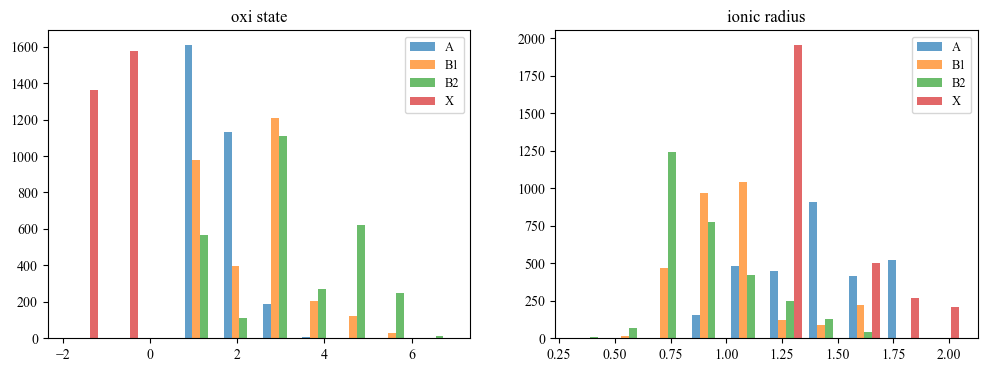

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
title = ["oxi state", "ionic radius"]
attrs = ["Os", "Ir"]
sites = ["A", "B1", "B2", "X"]
# ax1.hist([datas["A_Z"], datas["B1_Z"]],label=["A", "B1"])

# ax1.legend()
for ax, title, attr in zip(axs, title, attrs):
    seq = []
    site_seq = []
    for site in sites:
        site_attr = "$" + site+"_{"+ attr + "}$"
        seq.append(datas[site_attr])
        site_seq.append(site)
    ax.hist(seq, alpha=0.7, label=site_seq)
    ax.legend(fontsize=9)
    ax.set_title(title)
plt.show()

## 模型训练

使用默认参数训练模型，十折交叉验证结果表明，除了除了gbc以外，其他模型性能都很接近。其中xgb训练时间有点久，就不用它了

In [15]:
X_train, X_test, y_train, y_test = train_test_split(datas.iloc[:, 2:],datas.iloc[:, 1], test_size=0.2, random_state=7)

*特征缩放*
- 使用robustscaler效果甚微，可能很少离群值，后续特征融合时再尝试一下

In [16]:
gbc = Pipeline([
    ("Robustscaler", RobustScaler()),
    ("standardscaler", StandardScaler()),
    ("gbc", GradientBoostingClassifier())
]) 
gbc_score = cross_val_score(gbc, X_train, y_train, cv=KFold(10, shuffle=True))
gbc_score.mean()

0.8573849790871068

In [17]:
rfc = Pipeline([
    ("scaler", RobustScaler()),
    ("standardscaler", StandardScaler()),
    ("rfc", RandomForestClassifier())
]) 
rfc_score = cross_val_score(rfc, X_train, y_train, cv=KFold(10, shuffle=True))
rfc_score.mean()

0.8850591016548464

lightGBM

In [18]:
lgbm_model =Pipeline([
    ("scaler", RobustScaler()),
    ("standardscaler", StandardScaler()),
    ("lgbm", LGBMClassifier()),
]) 
lgbm_score = cross_val_score(lgbm_model, X_train, y_train, cv=KFold(10, shuffle=True))
lgbm_score.mean()

0.8922767775959265

In [19]:
eval_set = [(X_train, y_train), (X_test, y_test)]
lgbm_model.fit(X_train, y_train, 
               lgbm__eval_set=eval_set,     # 为clf传入验证集参数，方便后面画图
               lgbm__eval_metric=["auc","binary_logloss"],
               # lgbm__early_stopping_rounds=100
               lgbm__verbose=0, 
               )

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


LightGBMError: Do not support special JSON characters in feature name.

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

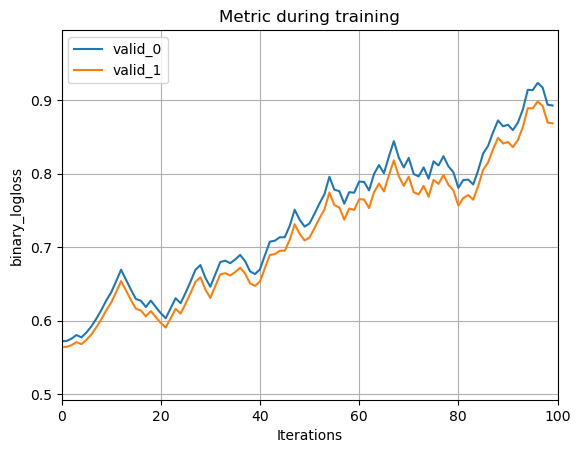

In [ ]:
lgb.plot_metric(lgbm_model[2].evals_result_, metric="binary_logloss")

catboost

In [ ]:
cat_model =Pipeline([
    ("scaler", RobustScaler()),
    ("standardscaler", StandardScaler()),
    ("cat", CatBoostClassifier(verbose=0)),
]) 
cat_score = cross_val_score(cat_model, X_train, y_train, cv=KFold(10, shuffle=True))
cat_score.mean()

0.8880323695217311

In [ ]:
cat_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('standardscaler', StandardScaler()),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x000001CB55718A90>)])

查看catboost和lightgbm的特征重要性

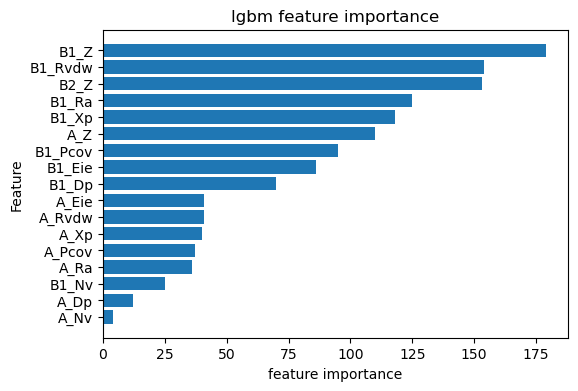

In [ ]:
# 只显示前十个
feature_importance = lgbm_model[2].feature_importances_[:17]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.barh(pos, feature_importance[sorted_idx], align="center")
ax.set_yticks(pos, X_train.columns[sorted_idx])
ax.set_xlabel("feature importance")
ax.set_ylabel("Feature")
ax.set_title("lgbm feature importance")
plt.show()

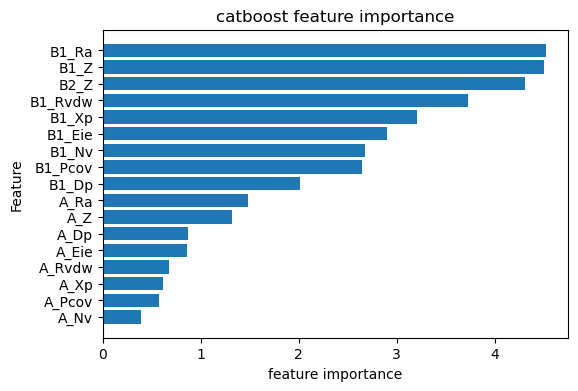

In [ ]:
# 只显示前十个
feature_importance = cat_model[2].feature_importances_[:17]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.barh(pos, feature_importance[sorted_idx], align="center")
ax.set_yticks(pos, X_train.columns[sorted_idx])
ax.set_xlabel("feature importance")
ax.set_ylabel("Feature")
ax.set_title("catboost feature importance")
plt.show()

使用特征递归消除法RFE尝试找到最佳的特征数量

In [ ]:
# from sklearn.feature_selection import RFECV

# catboost_rfe = RFECV(estimator=CatBoostClassifier(), step=1)
# lightbgm_rfe = RFECV(estimator=LGBMClassifier(), step=1)
# gbc_rfe = RFECV(estimator=GradientBoostingClassifier(), step=1)
# rf_rfe = RFECV(estimator=RandomForestClassifier(), step=1)

# catboost_rfe.fit(X_train, y_train)
# lightbgm_rfe.fit(X_train, y_train)
# rf_rfe.fit(X_train, y_train)
# gbc_rfe.fit(X_train, y_train)

# catboost_important_rank = catboost_rfe.ranking_
# lightbgm_important_rank = lightbgm_rfe.ranking_
# rf_important_rank = rf_rfe.ranking_
# gbc_important_rank = gbc_rfe.ranking_

保存模型

In [ ]:
# with open("catboost_rfe.pkl", "wb") as f:
#     pickle.dump(catboost_rfe, f)
# with open("lightbgm_rfe.pkl", "wb") as f:
#     pickle.dump(lightbgm_rfe, f)
# with open("rf_rfe.pkl", "wb") as f:
#     pickle.dump(rf_rfe, f)
# with open("gbc_rfe.pkl", "wb") as f:
#     pickle.dump(gbc_rfe, f)


读取模型

In [27]:
with open("catboost_rfe.pkl", "rb") as f:
    catboost_rfe = pickle.load(f)
with open("lightbgm_rfe.pkl", "rb") as f:
    lightbgm_rfe = pickle.load(f)
with open("rf_rfe.pkl", "rb") as f:
    rf_rfe = pickle.load(f)
with open("gbc_rfe.pkl", "rb") as f:
    gbc_rfe = pickle.load(f)

In [28]:
print(f"catboost中最好的特征个数{catboost_rfe.n_features_}")
print(f"lightbgm中最好的特征个数{lightbgm_rfe.n_features_}")
print(f"rf中最好的特征个数{rf_rfe.n_features_}")
print(f"gbc中最好的特征个数{gbc_rfe.n_features_}")


catboost中最好的特征个数35
lightbgm中最好的特征个数32
rf中最好的特征个数39
gbc中最好的特征个数14


In [29]:
catboost_important_rank = catboost_rfe.ranking_
lightbgm_important_rank = lightbgm_rfe.ranking_
rf_important_rank = rf_rfe.ranking_
gbc_important_rank = gbc_rfe.ranking_

cat_index = np.where(catboost_important_rank==1)[0]
light_index = np.where(lightbgm_important_rank==1)[0]
rf_index = np.where(rf_important_rank==1)[0]
gbc_index = np.where(gbc_important_rank==1)[0]

importance_features = []
for idx in cat_index:
    
    importance_features.append(X_train.columns[idx])
print(f"catboost的 importance features: {importance_features}")

importance_features = []
for idx in light_index:
    importance_features.append(X_train.columns[idx])
print(f"lightbgm的 importance features: {importance_features}")

importance_features = []
for idx in rf_index:
    importance_features.append(X_train.columns[idx])
print(f"rf的 importance features: {importance_features}")

importance_features = []
for idx in gbc_index:
    importance_features.append(X_train.columns[idx])
print(f"gbc的 importance features: {importance_features}")

catboost的 importance features: ['$A_{Z}$', '$A_{Ra}$', '$A_{Rvdw}$', '$A_{Xp}$', '$A_{Eie}$', '$A_{Dp}$', '$B1_{Z}$', '$B1_{Ra}$', '$B1_{Rvdw}$', '$B1_{Pcov}$', '$B1_{Xp}$', '$B1_{Nv}$', '$B1_{Eie}$', '$B1_{Dp}$', '$B2_{Z}$', '$B2_{Ra}$', '$B2_{Rvdw}$', '$B2_{Pcov}$', '$B2_{Xp}$', '$B2_{Nv}$', '$B2_{Eie}$', '$B2_{Dp}$', '$X_{Z}$', '$X_{Ra}$', '$X_{Rvdw}$', '$X_{Pcov}$', '$X_{Xp}$', '$X_{Eie}$', '$X_{Dp}$', '$B1_{Os}$', '$B2_{Os}$', '$A_{Ir}$', '$B1_{Ir}$', '$B2_{Ir}$', '$X_{Ir}$']
lightbgm的 importance features: ['$A_{Z}$', '$A_{Ra}$', '$A_{Rvdw}$', '$A_{Pcov}$', '$A_{Xp}$', '$A_{Nv}$', '$A_{Eie}$', '$A_{Dp}$', '$B1_{Z}$', '$B1_{Ra}$', '$B1_{Rvdw}$', '$B1_{Pcov}$', '$B1_{Xp}$', '$B1_{Nv}$', '$B1_{Eie}$', '$B1_{Dp}$', '$B2_{Z}$', '$B2_{Ra}$', '$B2_{Rvdw}$', '$B2_{Pcov}$', '$B2_{Xp}$', '$B2_{Nv}$', '$B2_{Eie}$', '$B2_{Dp}$', '$X_{Z}$', '$X_{Ra}$', '$X_{Xp}$', '$B1_{Os}$', '$B2_{Os}$', '$A_{Ir}$', '$B1_{Ir}$', '$B2_{Ir}$']
rf的 importance features: ['$A_{Z}$', '$A_{Ra}$', '$A_{Rvdw}$', '$A_

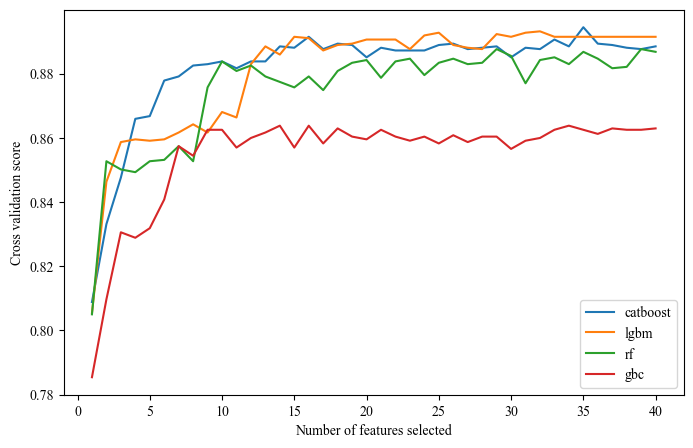

In [30]:
fig = plt.figure(figsize=(8, 5))
axs = fig.subplots()
axs.plot((range(1, len(catboost_rfe.cv_results_['mean_test_score']) + 1)), catboost_rfe.cv_results_['mean_test_score'], label="catboost")
axs.plot((range(1, len(lightbgm_rfe.cv_results_['mean_test_score']) + 1)), lightbgm_rfe.cv_results_['mean_test_score'], label="lgbm")
axs.plot((range(1, len(rf_rfe.cv_results_['mean_test_score']) + 1)), rf_rfe.cv_results_['mean_test_score'], label="rf")
axs.plot((range(1, len(gbc_rfe.cv_results_['mean_test_score']) + 1)), gbc_rfe.cv_results_['mean_test_score'], label="gbc")


axs.set_xlabel("Number of features selected")
axs.set_ylabel("Cross validation score")
axs.legend()
plt.show()


In [31]:
def acu_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()
    

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- $A_{Dp}$
- $A_{Eie}$
- $A_{Ir}$
- $A_{Nv}$
- $A_{Os}$
- ...
Feature names seen at fit time, yet now missing:
- A_Dp
- A_Eie
- A_Ir
- A_Nv
- A_Os
- ...


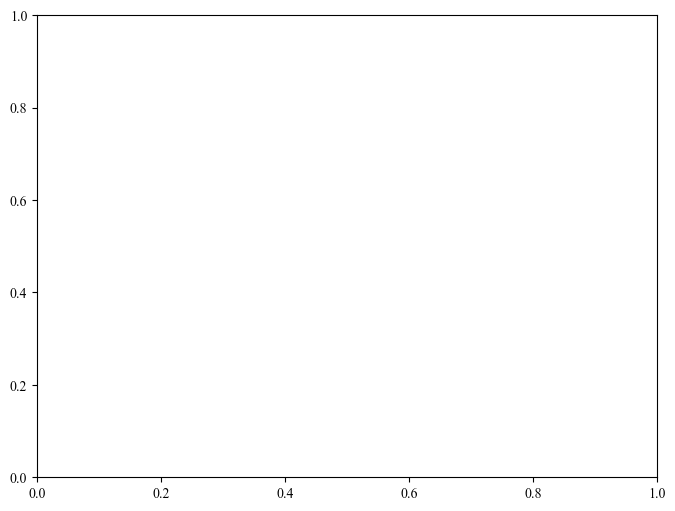

In [32]:
# 画出各模型的roc曲线
plt.subplots(figsize=(8, 6))

model_list = [gbc_rfe, rf_rfe, catboost_rfe, lightbgm_rfe]
model_name = ['gbc_rfe', 'rf_rfe', 'catboost_rfe', 'lightbgm_rfe']
for model, name in zip(model_list, model_name):
    fpr, tpr, threshold = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.legend()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- $A_{Dp}$
- $A_{Eie}$
- $A_{Ir}$
- $A_{Nv}$
- $A_{Os}$
- ...
Feature names seen at fit time, yet now missing:
- A_Dp
- A_Eie
- A_Ir
- A_Nv
- A_Os
- ...


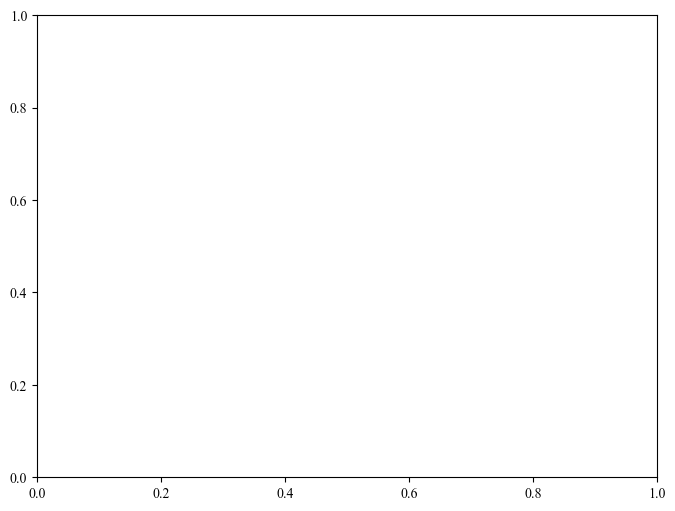

In [33]:
# 画出各模型测试集的roc曲线
plt.subplots(figsize=(8, 6))

model_list = [gbc_rfe, rf_rfe, catboost_rfe, lightbgm_rfe]
model_name = ['GBC', 'RF', 'Catboost', 'Lightbgm']
for model, name in zip(model_list, model_name):
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    plt.legend()
    plt.title("Receiver Operating Characteristic")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', alpha=0.5)

特征筛选后的模型效果

In [ ]:
lgbm10fold = lightbgm_rfe.cv_results_["mean_test_score"].max()
catboost10fold = catboost_rfe.cv_results_["mean_test_score"].max()
rf10fold = rf_rfe.cv_results_["mean_test_score"].max()
gbc10fold = gbc_rfe.cv_results_["mean_test_score"].max()

lgbm_rfe_num_features = lightbgm_rfe.n_features_
catboost_rfe_num_features = catboost_rfe.n_features_
rf_rfe_num_features = rf_rfe.n_features_
gbc_rfe_num_features = gbc_rfe.n_features_

In [ ]:
print(f"lgbm最好的10foldacc:{lgbm10fold:.2f}, 使用特征数量:{lgbm_rfe_num_features}")
print(f"catboost最奖的10foldacc:{catboost10fold:.2f}, 使用特征数量:{catboost_rfe_num_features}")
print(f"rf最好的10foldacc:{rf10fold:.2f}, 使用特征数量:{rf_rfe_num_features}")
print(f"gbc最好的10foldacc:{gbc10fold:.2f}, 使用特征数量:{gbc_rfe_num_features}")

lgbm最好的10foldacc:0.89, 使用特征数量:32
catboost最奖的10foldacc:0.89, 使用特征数量:35
rf最好的10foldacc:0.89, 使用特征数量:34
gbc最好的10foldacc:0.86, 使用特征数量:9


看测试集上的效果

lgbm_rfe test
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       453
           1       0.76      0.84      0.80       135

    accuracy                           0.90       588
   macro avg       0.86      0.88      0.87       588
weighted avg       0.91      0.90      0.90       588



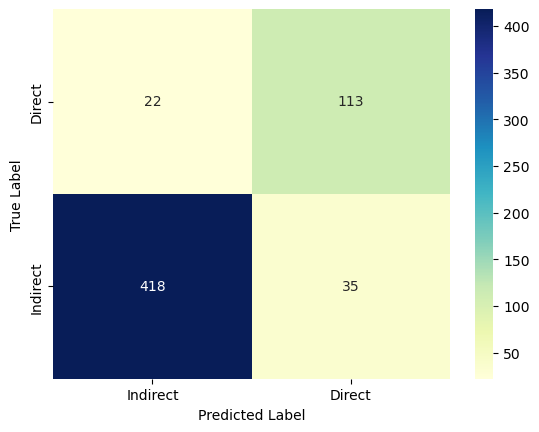

In [ ]:
print("lgbm_rfe test")
print(classification_report(lightbgm_rfe.predict(X_test), y_test))
C2 = confusion_matrix(lightbgm_rfe.predict(X_test), y_test)
sns.heatmap(C2[::-1], annot=True, fmt='d', cmap="YlGnBu")

plt.xticks([0.5, 1.5], labels=['Indirect', 'Direct'])
plt.yticks([0.5, 1.5], labels=['Direct', 'Indirect'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(lightbgm_rfe.predict(X_test), y_test)

array([[418,  35],
       [ 22, 113]], dtype=int64)

In [ ]:
print("catboost_rfe test")
print(classification_report(catboost_rfe.predict(X_test), y_test))

catboost_rfe test
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       458
           1       0.74      0.84      0.78       130

    accuracy                           0.90       588
   macro avg       0.84      0.88      0.86       588
weighted avg       0.90      0.90      0.90       588



In [ ]:
print("rf_rfe test")
print(classification_report(rf_rfe.predict(X_test), y_test))

rf_rfe test
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       447
           1       0.78      0.82      0.80       141

    accuracy                           0.90       588
   macro avg       0.86      0.87      0.86       588
weighted avg       0.90      0.90      0.90       588



In [ ]:
print("gbc_rfe test")
print(classification_report(gbc_rfe.predict(X_test), y_test))

gbc_rfe test
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       481
           1       0.64      0.89      0.75       107

    accuracy                           0.89       588
   macro avg       0.81      0.89      0.84       588
weighted avg       0.91      0.89      0.90       588



对比没有经过RFE的模型 ~~没什么区别。。。其实也正常~~

随机搜索超参数优化 ~~越优化越差，放弃了。。。。~~

In [ ]:
# # 参数要全部按照传给pipiline的格式来写
# random_params = {
#     # "learning_rate": np.arange(0.01, 0.1, step=0.01),
#     "lgbm__n_estimators": [500, 1000, 2000],
#     "lgbm__max_depth": [3, 4, 5],
#     "lgbm__num_leaves": [5, 6, 7, 12, 13, 14, 15, 28, 29, 30, 31],
#     "lgbm__subsample": [0.8, 0.9, 1],
#     "lgbm__learning_rate": np.arange(0.01, 0.2, step=0.01),
#     "lgbm__early_stopping_rounds": [100],
#     "lgbm__reg_alpha": np.arange(np.log(1), np.log(1000), step=0.01),

#     # "lgbm__eval_metric": ["binary_logloss"],
# }

# random_cv = RandomizedSearchCV(lgbm_model, random_params, n_iter=1000, cv=5)

In [ ]:
# %%time
# _ = random_cv.fit(X_train, y_train, lgbm__eval_set=eval_set)

In [ ]:
# best_lgbm_est = random_cv.best_estimator_
# with open("best_cv_lgbmclf.pkl", "wb") as f:
#     pickle.dump(best_lgbm_est, f)

Trying to unpickle estimator RobustScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator Pipeline from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or 

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

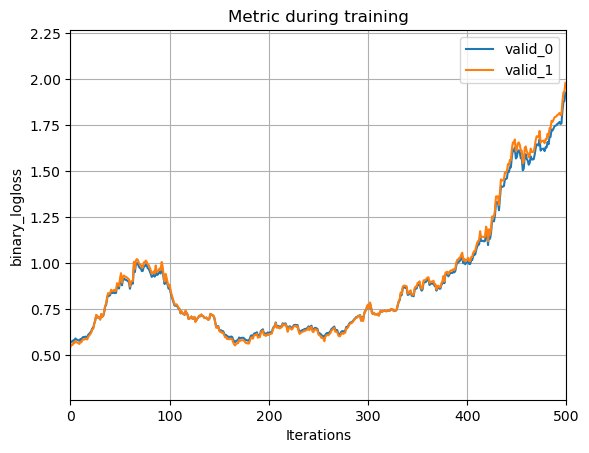

In [ ]:
with open("best_cv_lgbmclf.pkl", "rb") as f:
    best_lgbm_est = pickle.load(f)
lgb.plot_metric(best_lgbm_est[2].evals_result_, metric="binary_logloss")

In [ ]:
# print(classification_report(best_lgbm_est.predict(X_train), y_train))

In [ ]:
# print(classification_report(best_lgbm_est.predict(X_test), y_test))

## 给出有promising的直接带隙双钙钛矿材料

In [ ]:
screened_datas = pd.read_csv("预测稳定且取出特征空值的数据.csv", index_col=0)
screened_datas.head(2)

,formula,A_Z,A_Ra,A_Rvdw,A_Pcov,A_Xp,A_Nv,A_Eie,A_Dp,B1_Z,...,X_Eie,X_Dp,A_Os,B1_Os,B2_Os,X_Os,A_Ir,B1_Ir,B2_Ir,X_Ir
0,Na2 B1 Re1 O6,11,225,298.3,155.0,0.93,1.0,495.8,162.7,5,...,1313.9,5.3,1.0,3.0,7.0,-2.0,1.16,0.41,0.67,1.26
1,Na2 B1 Np1 O6,11,225,298.3,155.0,0.93,1.0,495.8,162.7,5,...,1313.9,5.3,1.0,3.0,7.0,-2.0,1.16,0.41,0.85,1.26


In [ ]:
screened_datas["is_direct_gap"] = lgbm_model.predict(screened_datas.iloc[:, 1:])

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- A_Dp
- A_Eie
- A_Ir
- A_Nv
- A_Os
- ...
Feature names seen at fit time, yet now missing:
- $A_{Dp}$
- $A_{Eie}$
- $A_{Ir}$
- $A_{Nv}$
- $A_{Os}$
- ...


In [ ]:
screened_datas["is_direct_gap"].value_counts()

0    20119
1      919
Name: is_direct_gap, dtype: int64

In [ ]:
promising_datas = screened_datas[screened_datas["is_direct_gap"] == 1]
promising_datas.to_csv("promising_direct_gap_datas.csv", index=False)

In [ ]:
promising_Br_datas = promising_datas[promising_datas['formula'].str.contains('Br6')]
promising_Br_datas.to_csv('promising_Br_datas.csv', index=False)

## 尝试解释

In [26]:
explainer = shap.TreeExplainer(lgbm_model[2])
shap_values = explainer.shap_values(X_train)  # shap数值
shap_values2 = explainer(X_train)

NotFittedError: No classes found. Need to call fit beforehand.

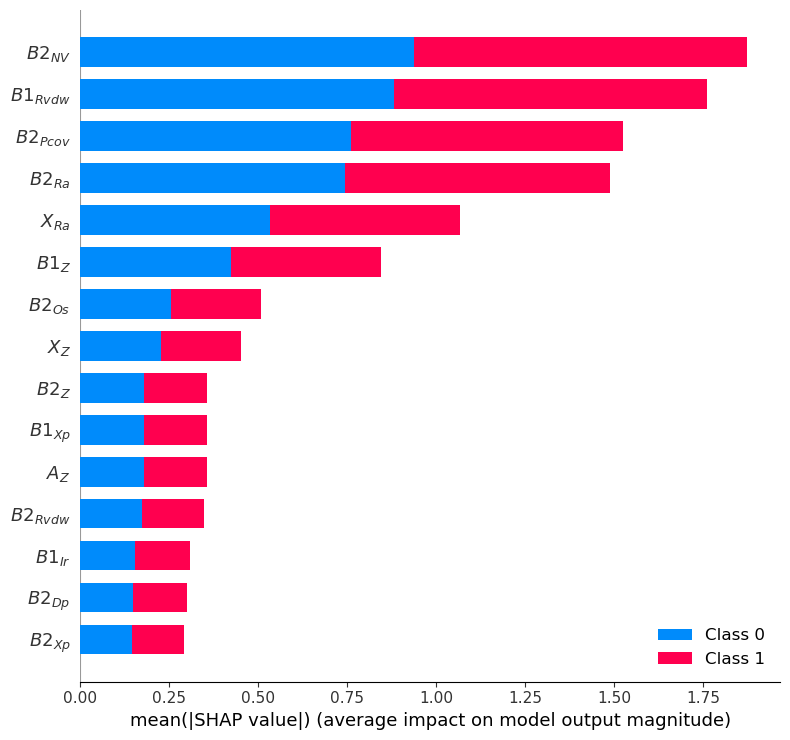

In [ ]:


shap.summary_plot(shap_values, X_train.rename(columns=col_name_dicts), plot_type="bar", max_display=15)

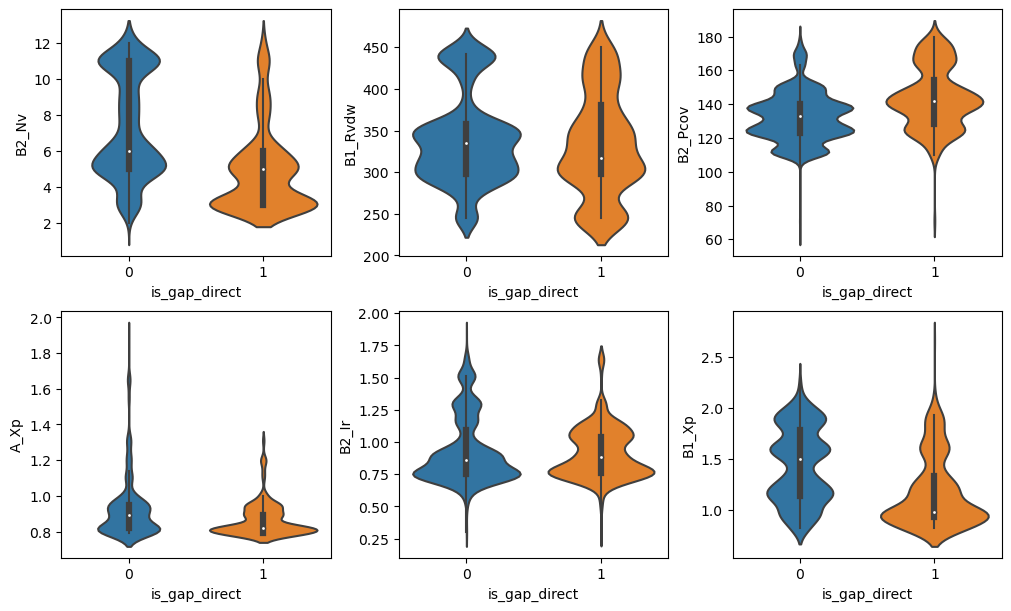

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), layout="constrained")
importance_features = ["B2_Nv", "B1_Rvdw", "B2_Pcov", "A_Xp", "B2_Ir", "B1_Xp"]
for ax, feature in zip(axs.flat, importance_features):
    sns.violinplot(datas, x="is_gap_direct", y=feature, ax=ax)

In [ ]:
datas.head(2)

,regular_formula,is_gap_direct,A_Z,A_Ra,A_Rvdw,A_Pcov,A_Xp,A_Nv,A_Eie,A_Dp,...,X_Eie,X_Dp,A_Os,B1_Os,B2_Os,X_Os,A_Ir,B1_Ir,B2_Ir,X_Ir
0,Sr2 Hf1 W1 O6,0,38,279,364.1,185.0,0.95,2.0,549.5,197.2,...,1313.9,5.3,2.0,4.0,4.0,-2.0,1.32,0.850,0.80,1.26
1,Cs2 Al1 Au1 I6,0,55,249,451.7,232.0,0.79,1.0,375.7,400.9,...,1008.4,32.9,1.0,3.0,1.0,-1.0,1.81,0.675,1.51,2.06


In [ ]:
# 画树图，不好看。。。。。
# import lightgbm as lgb
# ax = lgb.plot_tree(lgbm_model[1], figsize=(40, 20))

In [25]:
# shap_values = explainer.shap_values(datas.iloc[:, 1:])  # shap数值
shap.dependence_plot("$A_{Xp}$", shap_values[1], X_train.rename(columns=col_name_dicts), interaction_index=None)
shap.dependence_plot("$B1_{Xp}$", shap_values[1], X_train.rename(columns=col_name_dicts), interaction_index=None)
shap.dependence_plot("$B2_{Ir}$", shap_values[1], X_train.rename(columns=col_name_dicts), interaction_index=None)

NameError: name 'shap_values' is not defined

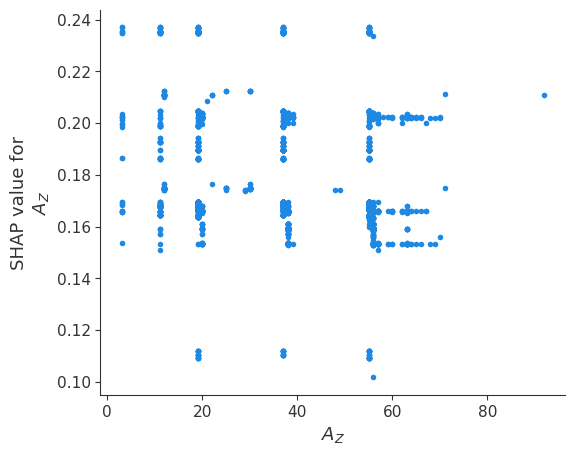

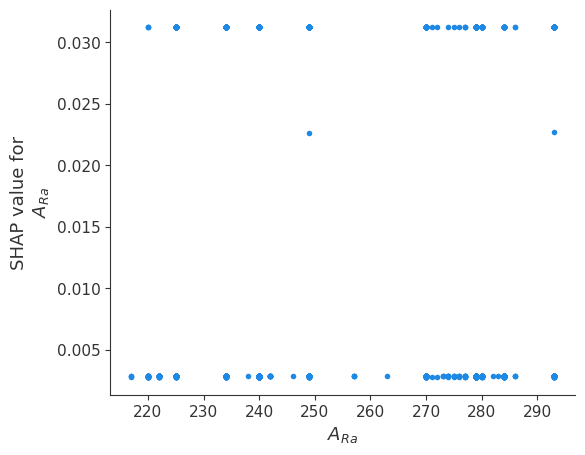

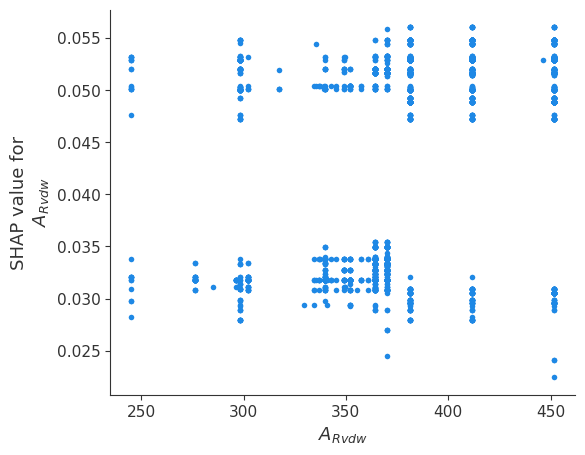

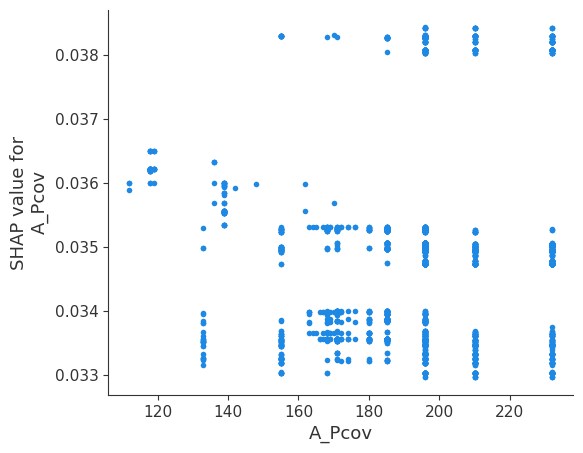

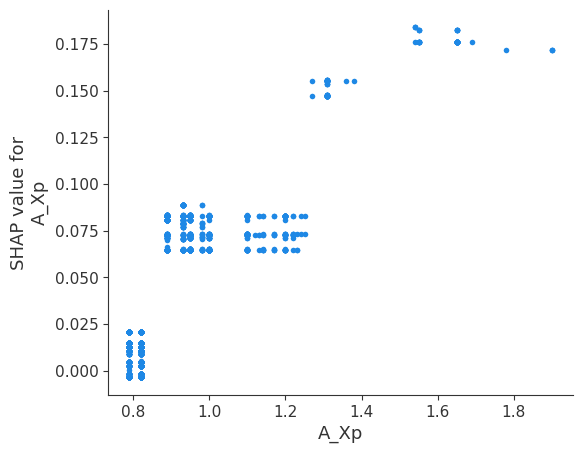

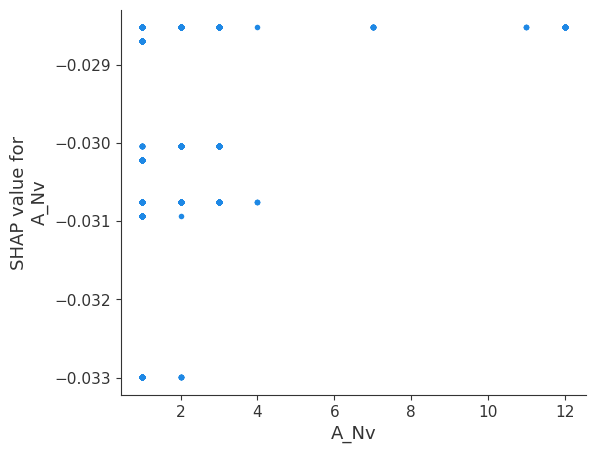

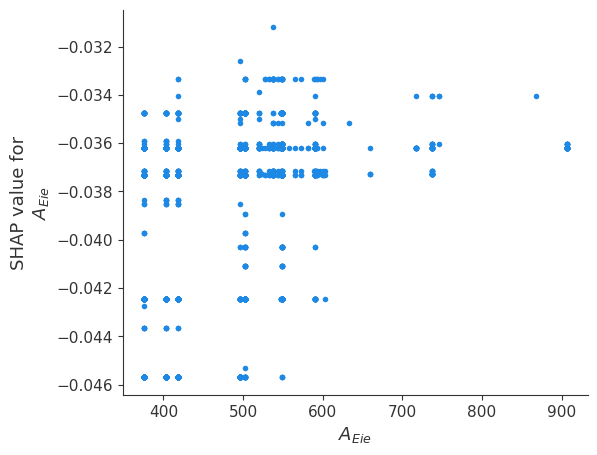

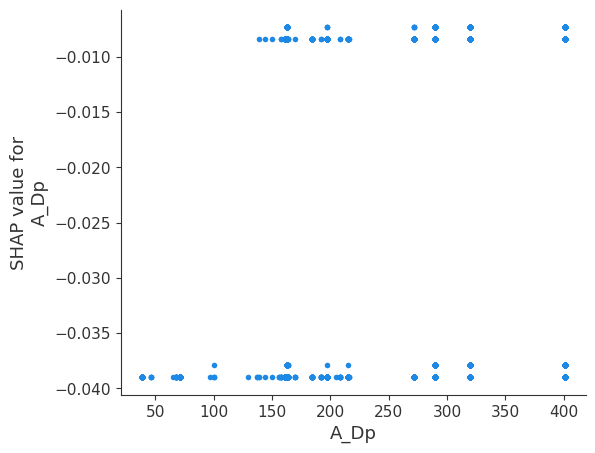

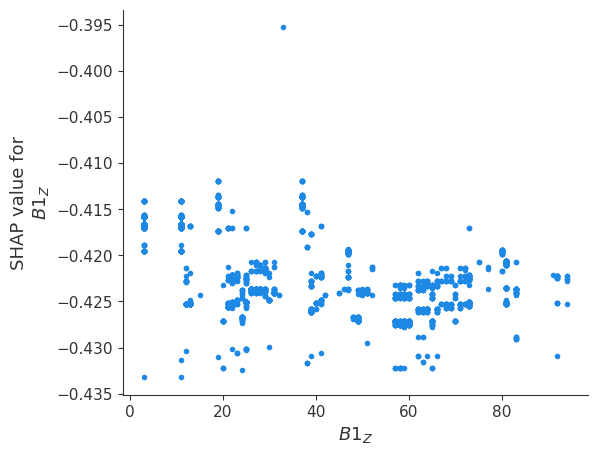

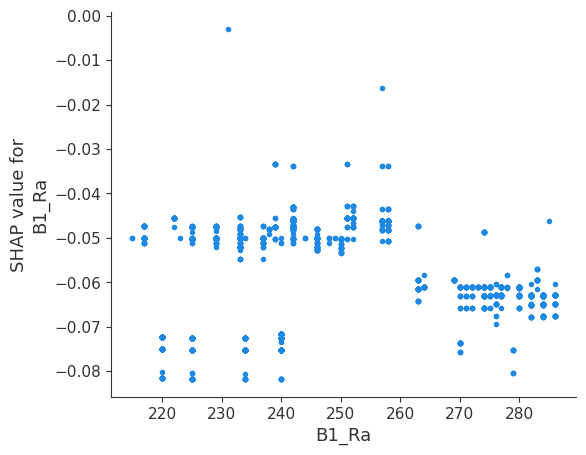

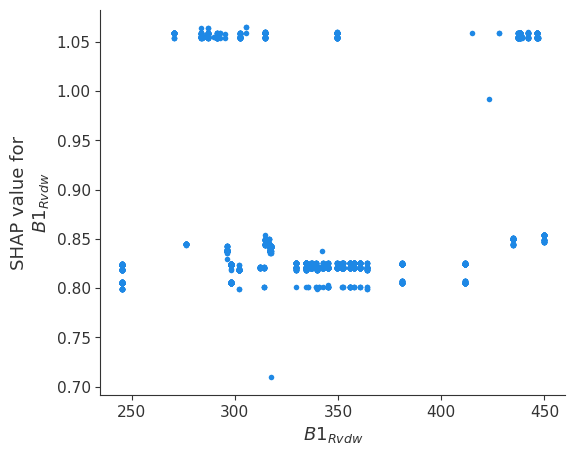

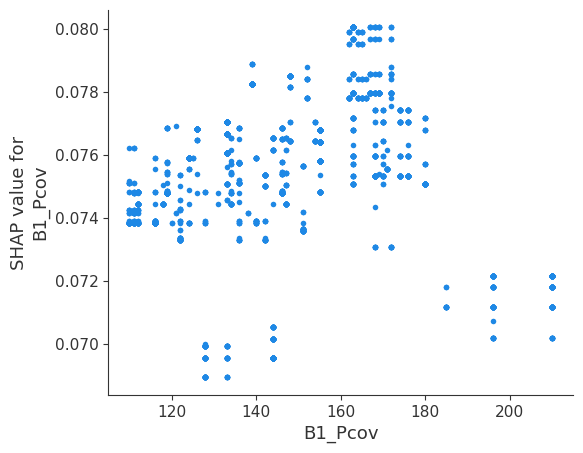

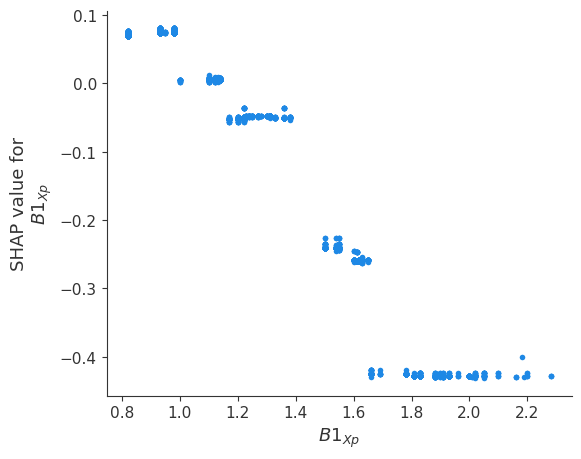

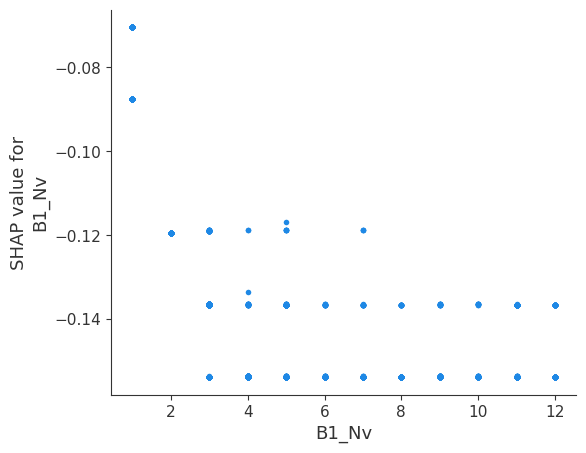

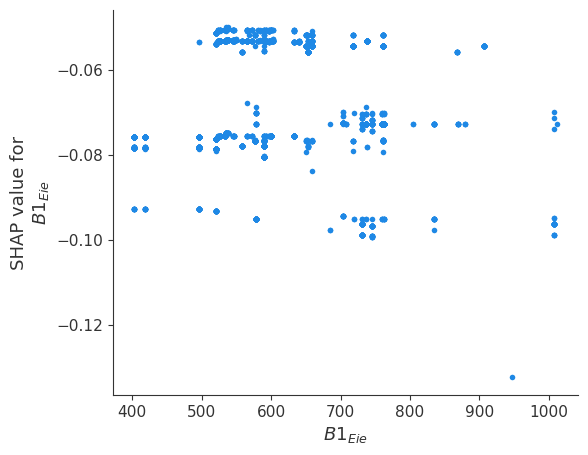

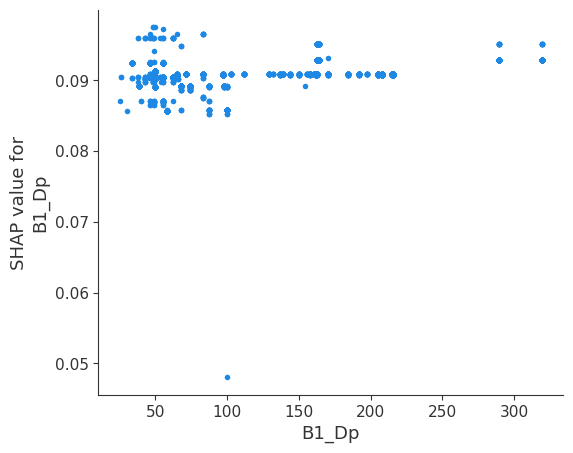

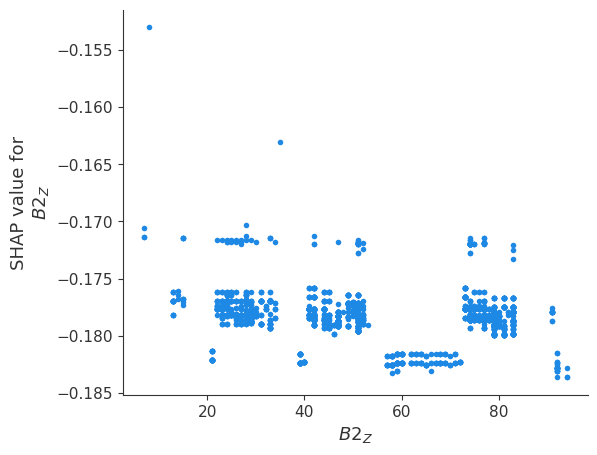

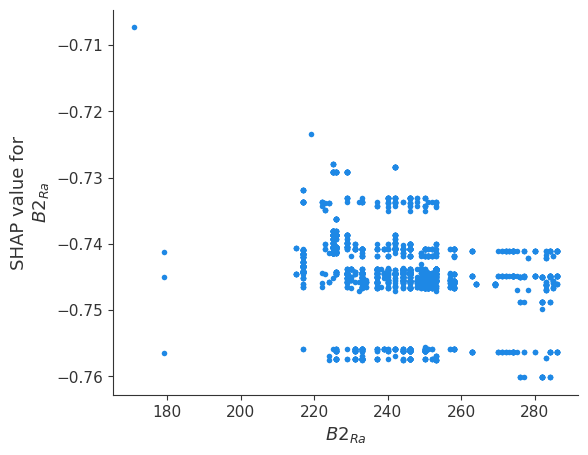

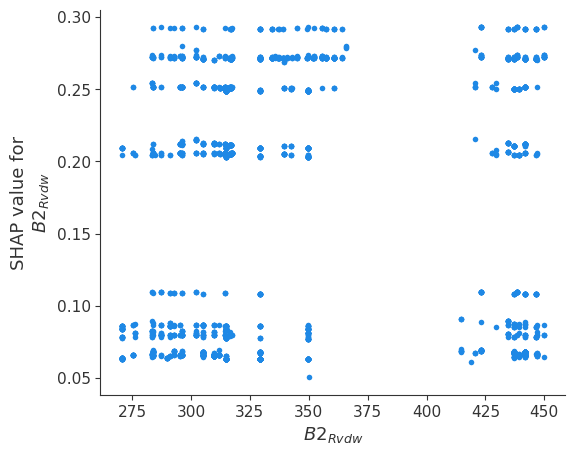

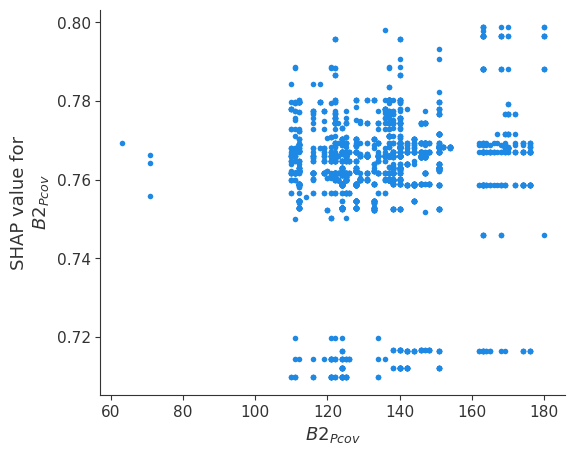

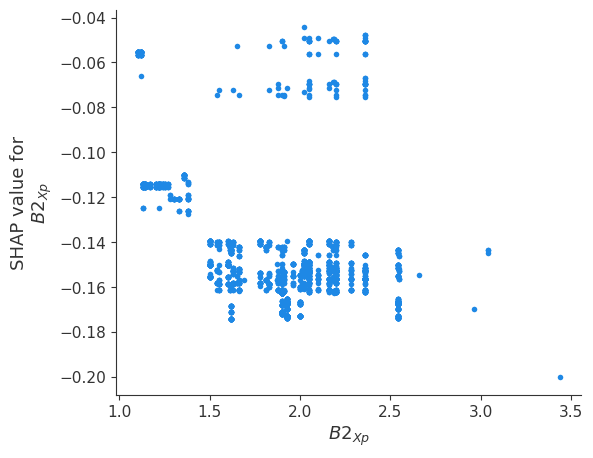

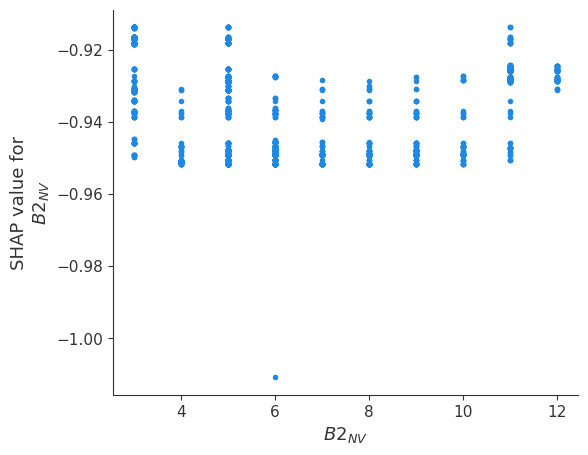

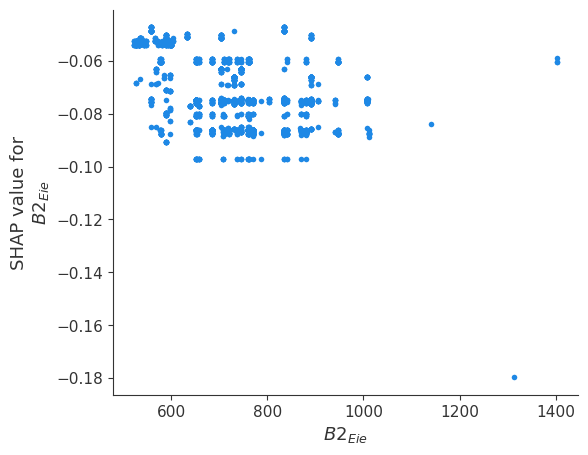

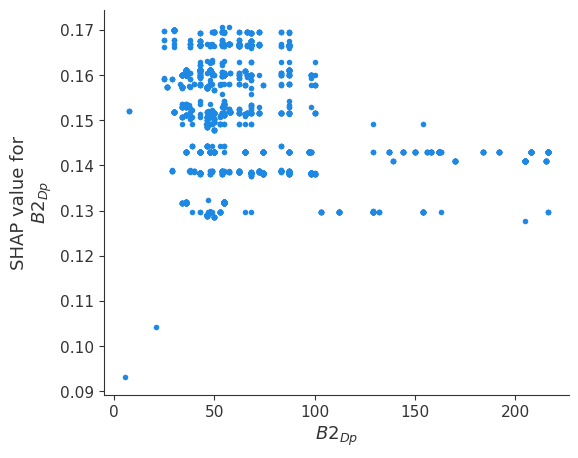

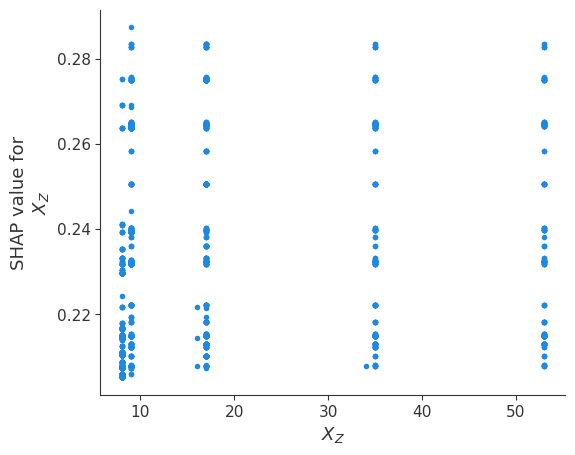

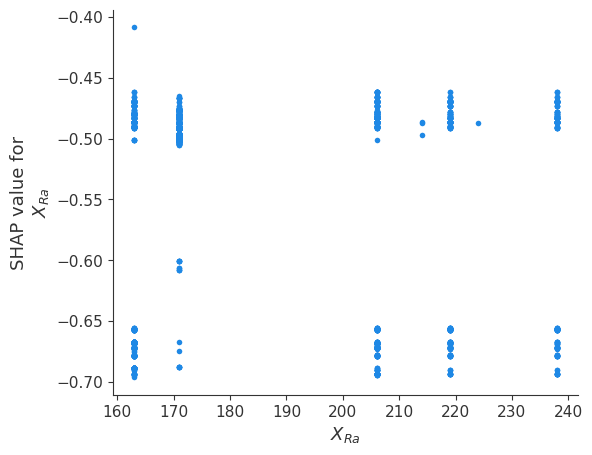

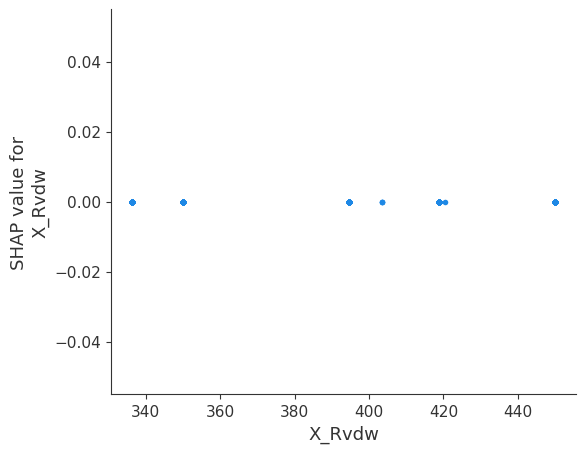

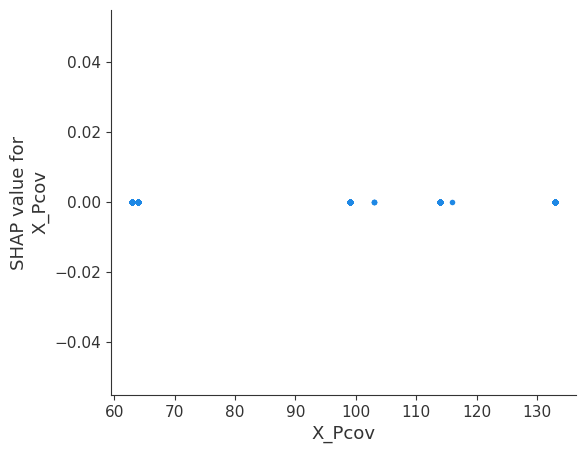

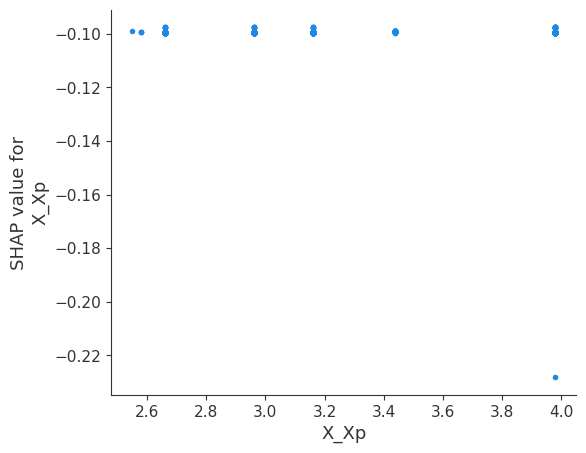

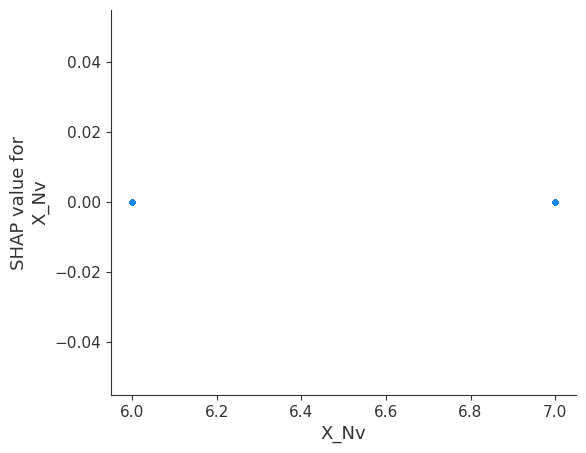

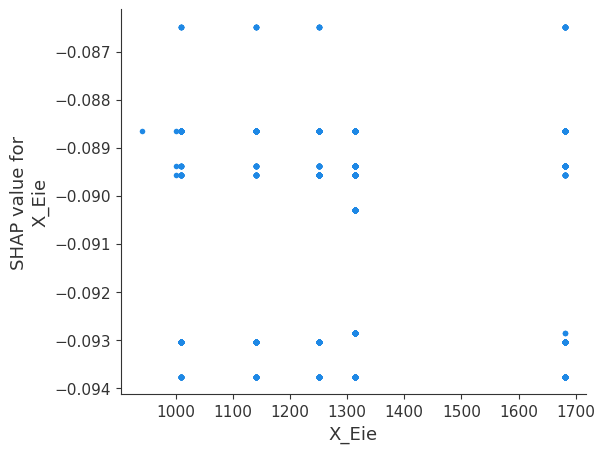

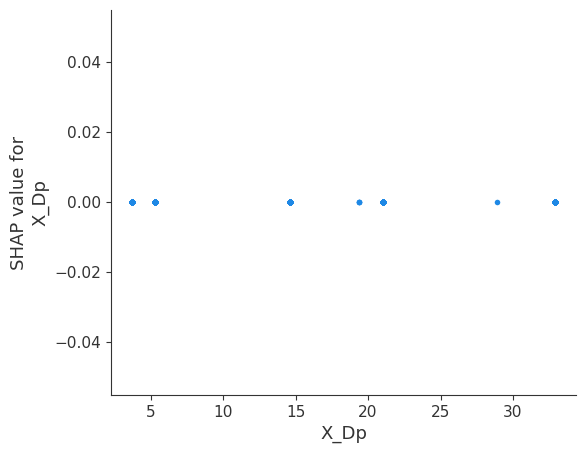

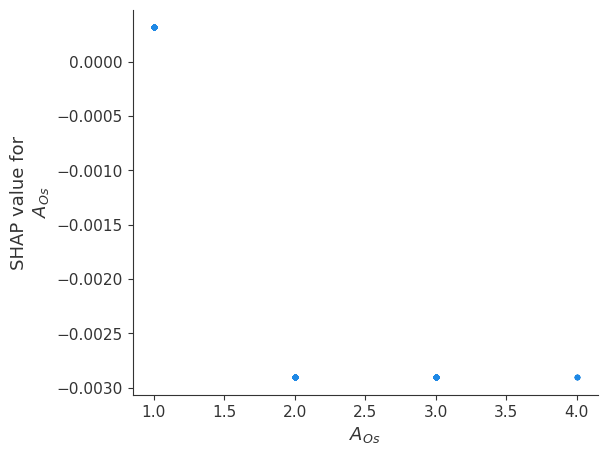

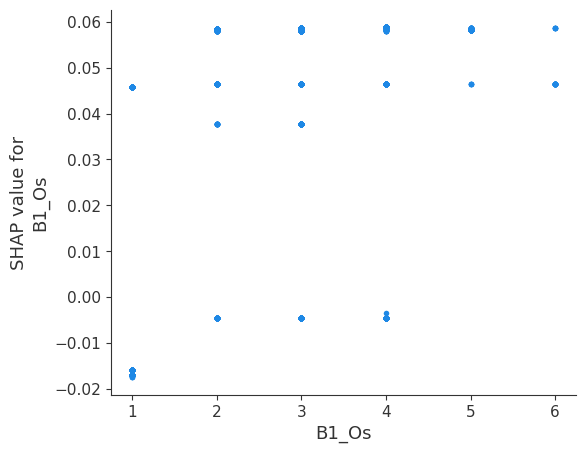

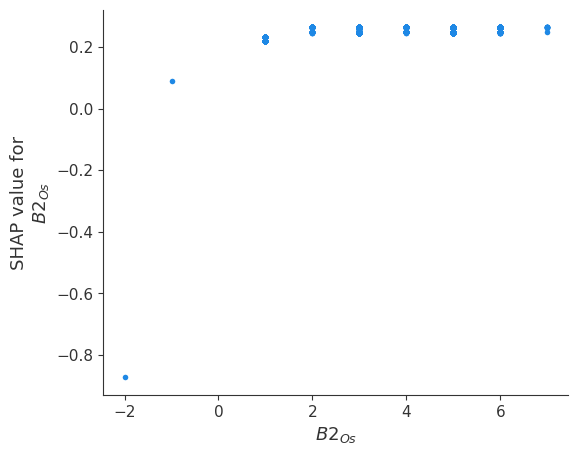

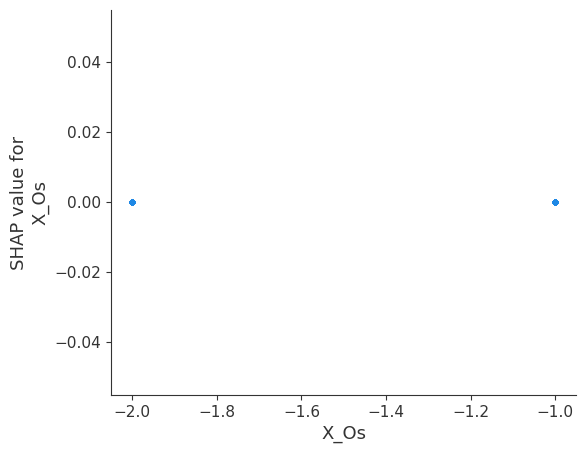

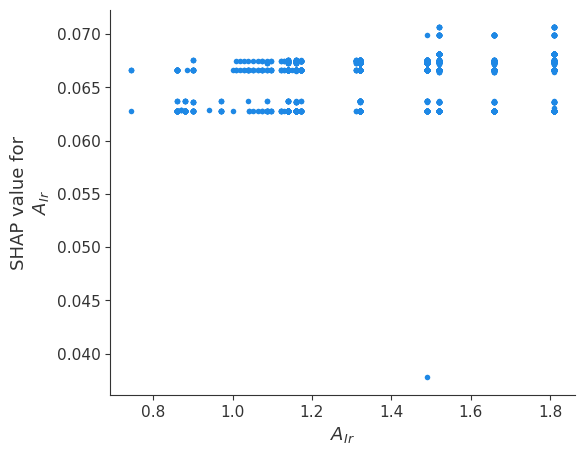

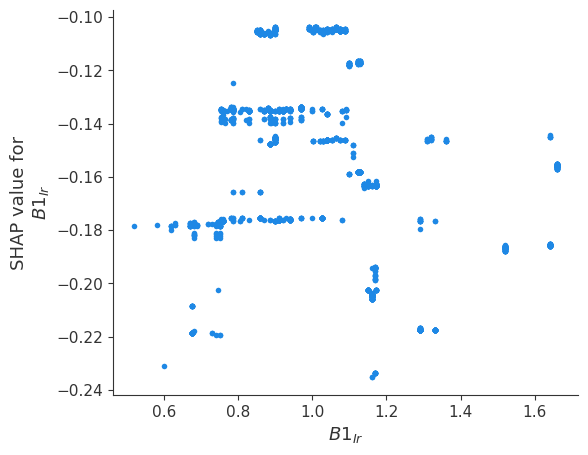

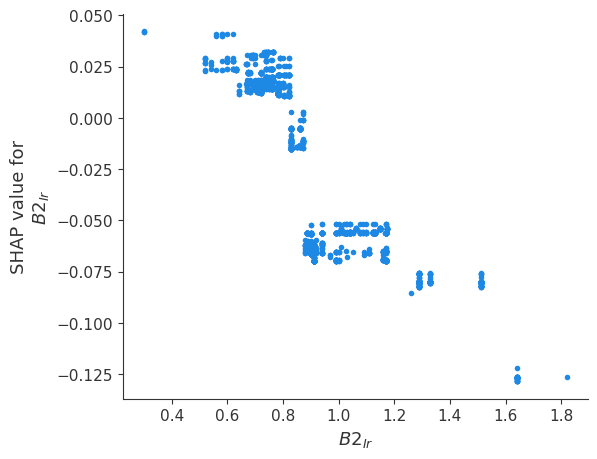

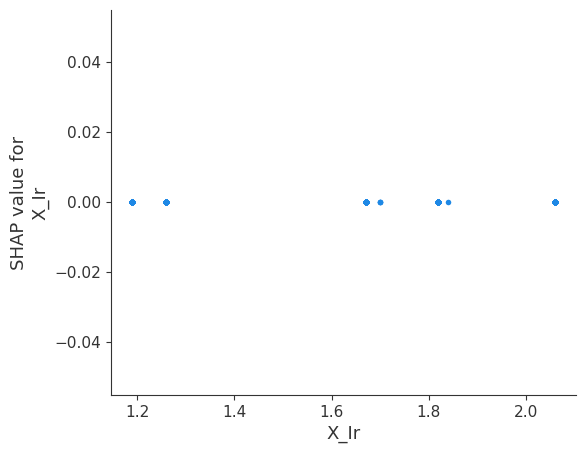

In [ ]:
# 一塌糊涂的看不出任何依赖的依赖图
# for name in X_train.rename(columns=col_name_dicts).columns:
#     # shap.dependence_plot(name, shap_values[1], X_train.rename(columns=col_name_dicts), display_features=X_train)
#     shap.dependence_plot(name, shap_values[1], X_train.rename(columns=col_name_dicts), interaction_index=None)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


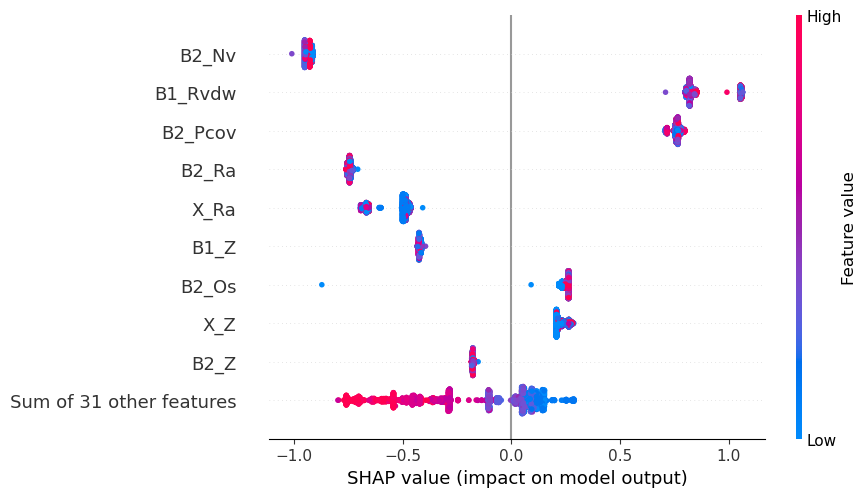

In [ ]:
shap.plots.beeswarm(shap_values2[:, :, 1])